In [10]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [11]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3


Using GPU: 2 with the lowest memory usage.


In [12]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [13]:
spot_size=50
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.9
dataset_name="hBreast"
kmeans_init=True
custom_init="mclust"
spatial_init=True
num_clusters=7
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=10.0
# uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
uncertainty_values = [0.25, 0.5, 0.75, 0.9, 0.99]
evaluate_markers=False
spatial_normalize=0.00

In [14]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [15]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [16]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, num_clusters=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=False, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=False, K=K)[1.0]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

100%|██████████| 23444/23444 [00:01<00:00, 16723.07it/s]


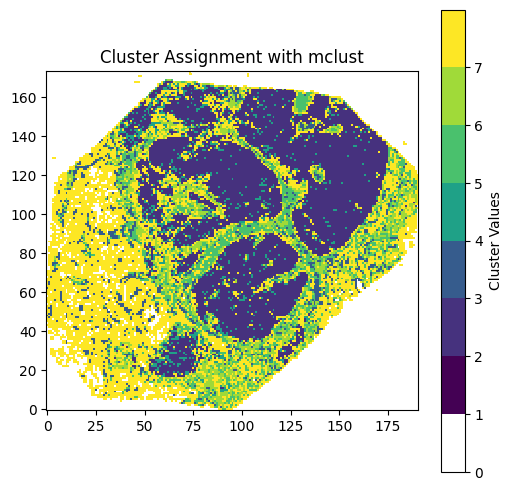

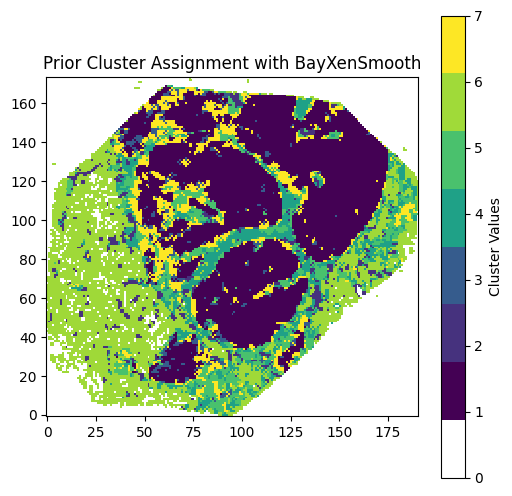

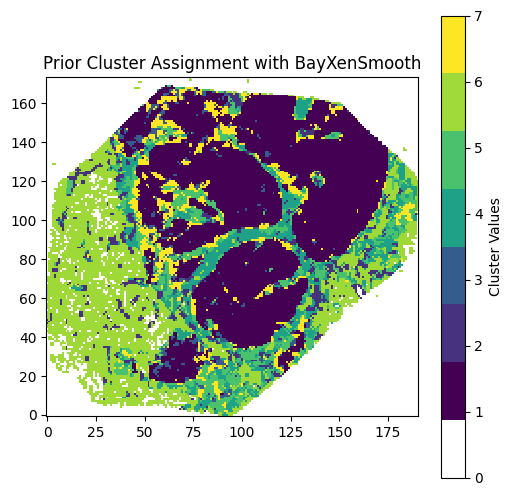

In [17]:
# Clamping
MIN_CONCENTRATION = 0.01

num_posterior_samples = 1000

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init, K=num_clusters)

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/mpd.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [18]:
# grab the mpd distance of cluster labels
mpd = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(mpd.values()) / 1_000_000

0.025412046137464853

In [19]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [20]:
learn_global_variances = True

In [21]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q_mean = pyro.param("cluster_means_q_mean", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q_mean = pyro.param("cluster_scales_q_mean", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        if learn_global_variances:
            cluster_means_q_scale = pyro.param("cluster_means_q_scale", torch.ones_like(empirical_prior_means) * 1.0, constraint=dist.constraints.positive)
            cluster_scales_q_scale = pyro.param("cluster_scales_q_scale", torch.ones_like(empirical_prior_scales) * 0.25, constraint=dist.constraints.positive)
            cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q_mean, cluster_means_q_scale).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q_mean, cluster_scales_q_scale).to_event(1))
        else:
            cluster_means = pyro.sample("cluster_means", dist.Delta(cluster_means_q_mean).to_event(1))
            cluster_scales = pyro.sample("cluster_scales", dist.Delta(cluster_scales_q_mean).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [22]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([7, 3]), torch.Size([7, 3]))

In [23]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [24]:
pyro.clear_param_store()
NUM_EPOCHS = 100
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q_mean':
        return {"lr": 0.005, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q_mean':
        return {"lr": 0.001, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.005, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 10
patience_counter = 0
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q_mean").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q_mean").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        # print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])


        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 1:   1%|          | 1/100 [00:01<02:36,  1.58s/it]

Epoch 0 : loss = 12431.0089
tensor([0.0101, 0.0075, 0.0103, 0.0087, 0.0104, 0.9444, 0.0086],
       dtype=torch.float64)


Epoch 2:   2%|▏         | 2/100 [00:02<01:55,  1.18s/it]

Epoch 1 : loss = 11892.9337
tensor([0.0101, 0.0075, 0.0103, 0.0087, 0.0104, 0.9444, 0.0086],
       dtype=torch.float64)


Epoch 3:   3%|▎         | 3/100 [00:03<01:42,  1.05s/it]

Epoch 2 : loss = 11433.6686
tensor([0.0101, 0.0082, 0.0102, 0.0095, 0.0104, 0.9421, 0.0095],
       dtype=torch.float64)


Epoch 4:   4%|▍         | 4/100 [00:04<01:35,  1.01it/s]

Epoch 3 : loss = 11089.1187
tensor([0.0091, 0.0083, 0.0095, 0.0096, 0.0095, 0.9445, 0.0094],
       dtype=torch.float64)


Epoch 5:   5%|▌         | 5/100 [00:05<01:30,  1.05it/s]

Epoch 4 : loss = 10792.8992
tensor([0.0091, 0.0084, 0.0092, 0.0095, 0.0093, 0.9452, 0.0093],
       dtype=torch.float64)


Epoch 6:   6%|▌         | 6/100 [00:06<01:28,  1.07it/s]

Epoch 5 : loss = 10593.5378
tensor([0.0092, 0.0084, 0.0091, 0.0095, 0.0092, 0.9453, 0.0093],
       dtype=torch.float64)


Epoch 7:   7%|▋         | 7/100 [00:06<01:26,  1.07it/s]

Epoch 6 : loss = 10407.0057
tensor([0.0092, 0.0084, 0.0091, 0.0095, 0.0092, 0.9453, 0.0093],
       dtype=torch.float64)


Epoch 8:   8%|▊         | 8/100 [00:07<01:25,  1.08it/s]

Epoch 7 : loss = 10259.1376
tensor([0.0092, 0.0087, 0.0091, 0.0093, 0.0093, 0.9452, 0.0094],
       dtype=torch.float64)


Epoch 9:   9%|▉         | 9/100 [00:08<01:23,  1.08it/s]

Epoch 8 : loss = 10142.8093
tensor([0.0086, 0.0087, 0.0089, 0.0088, 0.0089, 0.9470, 0.0091],
       dtype=torch.float64)


Epoch 10:  10%|█         | 10/100 [00:09<01:22,  1.09it/s]

Epoch 9 : loss = 10061.5398
tensor([0.0092, 0.0091, 0.0092, 0.0093, 0.0093, 0.9445, 0.0093],
       dtype=torch.float64)


Epoch 11:  11%|█         | 11/100 [00:10<01:21,  1.09it/s]

Epoch 10 : loss = 9976.6655
tensor([0.0093, 0.0091, 0.0092, 0.0094, 0.0093, 0.9444, 0.0094],
       dtype=torch.float64)


Epoch 12:  12%|█▏        | 12/100 [00:11<01:20,  1.09it/s]

Epoch 11 : loss = 9921.7713
tensor([0.0089, 0.0087, 0.0087, 0.0088, 0.0086, 0.9474, 0.0090],
       dtype=torch.float64)


Epoch 13:  13%|█▎        | 13/100 [00:12<01:19,  1.09it/s]

Epoch 12 : loss = 9849.2081
tensor([0.0089, 0.0087, 0.0087, 0.0088, 0.0085, 0.9474, 0.0090],
       dtype=torch.float64)


Epoch 14:  14%|█▍        | 14/100 [00:13<01:18,  1.10it/s]

Epoch 13 : loss = 9790.9327
tensor([0.0085, 0.0088, 0.0086, 0.0093, 0.0088, 0.9470, 0.0090],
       dtype=torch.float64)


Epoch 15:  15%|█▌        | 15/100 [00:14<01:17,  1.09it/s]

Epoch 14 : loss = 9728.2977
tensor([0.0085, 0.0089, 0.0086, 0.0093, 0.0088, 0.9469, 0.0090],
       dtype=torch.float64)


Epoch 16:  16%|█▌        | 16/100 [00:15<01:16,  1.10it/s]

Epoch 15 : loss = 9694.6355
tensor([0.0085, 0.0089, 0.0086, 0.0093, 0.0088, 0.9469, 0.0090],
       dtype=torch.float64)


Epoch 17:  17%|█▋        | 17/100 [00:16<01:15,  1.10it/s]

Epoch 16 : loss = 9647.3839
tensor([0.0081, 0.0082, 0.0077, 0.0080, 0.0081, 0.9518, 0.0081],
       dtype=torch.float64)


Epoch 18:  18%|█▊        | 18/100 [00:17<01:14,  1.10it/s]

Epoch 17 : loss = 9639.0132
tensor([0.0081, 0.0082, 0.0077, 0.0079, 0.0081, 0.9520, 0.0081],
       dtype=torch.float64)


Epoch 19:  19%|█▉        | 19/100 [00:17<01:13,  1.10it/s]

Epoch 18 : loss = 9602.4427
tensor([0.0084, 0.0080, 0.0079, 0.0081, 0.0081, 0.9517, 0.0078],
       dtype=torch.float64)


Epoch 20:  20%|██        | 20/100 [00:18<01:12,  1.10it/s]

Epoch 19 : loss = 9562.8081
tensor([0.0084, 0.0080, 0.0078, 0.0081, 0.0083, 0.9516, 0.0078],
       dtype=torch.float64)


Epoch 21:  21%|██        | 21/100 [00:19<01:11,  1.10it/s]

Epoch 20 : loss = 9524.4871
tensor([0.0084, 0.0080, 0.0078, 0.0081, 0.0083, 0.9516, 0.0078],
       dtype=torch.float64)


Epoch 22:  22%|██▏       | 22/100 [00:20<01:11,  1.10it/s]

Epoch 21 : loss = 9493.7968
tensor([0.0075, 0.0075, 0.0073, 0.0075, 0.0072, 0.9557, 0.0072],
       dtype=torch.float64)


Epoch 23:  23%|██▎       | 23/100 [00:21<01:10,  1.10it/s]

Epoch 22 : loss = 9473.7194
tensor([0.0077, 0.0073, 0.0075, 0.0075, 0.0074, 0.9555, 0.0073],
       dtype=torch.float64)


Epoch 24:  24%|██▍       | 24/100 [00:22<01:09,  1.10it/s]

Epoch 23 : loss = 9454.9852
tensor([0.0077, 0.0075, 0.0080, 0.0081, 0.0075, 0.9536, 0.0076],
       dtype=torch.float64)


Epoch 25:  25%|██▌       | 25/100 [00:23<01:08,  1.10it/s]

Epoch 24 : loss = 9430.5247
tensor([0.0077, 0.0075, 0.0080, 0.0081, 0.0075, 0.9536, 0.0076],
       dtype=torch.float64)


Epoch 26:  26%|██▌       | 26/100 [00:24<01:07,  1.10it/s]

Epoch 25 : loss = 9394.7494
tensor([0.0077, 0.0075, 0.0080, 0.0081, 0.0075, 0.9536, 0.0076],
       dtype=torch.float64)


Epoch 27:  27%|██▋       | 27/100 [00:25<01:06,  1.10it/s]

Epoch 26 : loss = 9390.5161
tensor([0.0074, 0.0072, 0.0075, 0.0076, 0.0074, 0.9555, 0.0074],
       dtype=torch.float64)


Epoch 28:  28%|██▊       | 28/100 [00:26<01:05,  1.10it/s]

Epoch 27 : loss = 9350.123
tensor([0.0075, 0.0073, 0.0076, 0.0077, 0.0076, 0.9548, 0.0075],
       dtype=torch.float64)


Epoch 29:  29%|██▉       | 29/100 [00:27<01:04,  1.10it/s]

Epoch 28 : loss = 9337.9653
tensor([0.0075, 0.0073, 0.0076, 0.0077, 0.0076, 0.9548, 0.0075],
       dtype=torch.float64)


Epoch 30:  30%|███       | 30/100 [00:27<01:03,  1.10it/s]

Epoch 29 : loss = 9345.2189
tensor([0.0079, 0.0074, 0.0075, 0.0076, 0.0078, 0.9544, 0.0075],
       dtype=torch.float64)


Epoch 31:  31%|███       | 31/100 [00:28<01:02,  1.10it/s]

Epoch 30 : loss = 9292.9518
tensor([0.0068, 0.0068, 0.0064, 0.0071, 0.0066, 0.9592, 0.0071],
       dtype=torch.float64)


Epoch 32:  32%|███▏      | 32/100 [00:29<01:01,  1.10it/s]

Epoch 31 : loss = 9301.5377
tensor([0.0065, 0.0066, 0.0065, 0.0067, 0.0064, 0.9604, 0.0069],
       dtype=torch.float64)


Epoch 33:  33%|███▎      | 33/100 [00:30<01:00,  1.10it/s]

Epoch 32 : loss = 9275.3553
tensor([0.0066, 0.0066, 0.0064, 0.0067, 0.0064, 0.9604, 0.0069],
       dtype=torch.float64)


Epoch 34:  34%|███▍      | 34/100 [00:31<01:00,  1.10it/s]

Epoch 33 : loss = 9232.8944
tensor([0.0066, 0.0066, 0.0064, 0.0067, 0.0064, 0.9604, 0.0069],
       dtype=torch.float64)


Epoch 35:  35%|███▌      | 35/100 [00:32<00:59,  1.10it/s]

Epoch 34 : loss = 9248.2822
tensor([0.0062, 0.0064, 0.0062, 0.0063, 0.0063, 0.9619, 0.0066],
       dtype=torch.float64)


Epoch 36:  36%|███▌      | 36/100 [00:33<00:58,  1.10it/s]

Epoch 35 : loss = 9213.5696
tensor([0.0065, 0.0063, 0.0063, 0.0063, 0.0062, 0.9621, 0.0063],
       dtype=torch.float64)


Epoch 37:  37%|███▋      | 37/100 [00:34<00:57,  1.10it/s]

Epoch 36 : loss = 9210.9125
tensor([0.0061, 0.0062, 0.0061, 0.0063, 0.0058, 0.9633, 0.0061],
       dtype=torch.float64)


Epoch 38:  38%|███▊      | 38/100 [00:35<00:56,  1.10it/s]

Epoch 37 : loss = 9211.1133
tensor([0.0066, 0.0063, 0.0062, 0.0064, 0.0061, 0.9619, 0.0065],
       dtype=torch.float64)


Epoch 39:  39%|███▉      | 39/100 [00:36<00:55,  1.10it/s]

Epoch 38 : loss = 9183.5317
tensor([0.0067, 0.0064, 0.0063, 0.0065, 0.0062, 0.9614, 0.0066],
       dtype=torch.float64)


Epoch 40:  40%|████      | 40/100 [00:37<00:54,  1.10it/s]

Epoch 39 : loss = 9185.6187
tensor([0.0067, 0.0064, 0.0063, 0.0065, 0.0062, 0.9614, 0.0066],
       dtype=torch.float64)


Epoch 41:  41%|████      | 41/100 [00:37<00:53,  1.10it/s]

Epoch 40 : loss = 9147.469
tensor([0.0066, 0.0066, 0.0061, 0.0067, 0.0064, 0.9614, 0.0063],
       dtype=torch.float64)


Epoch 42:  42%|████▏     | 42/100 [00:38<00:52,  1.10it/s]

Epoch 41 : loss = 9156.7334
tensor([0.0067, 0.0066, 0.0065, 0.0065, 0.0062, 0.9613, 0.0062],
       dtype=torch.float64)


Epoch 43:  43%|████▎     | 43/100 [00:39<00:51,  1.10it/s]

Epoch 42 : loss = 9147.5297
tensor([0.0067, 0.0066, 0.0065, 0.0065, 0.0062, 0.9613, 0.0062],
       dtype=torch.float64)


Epoch 44:  44%|████▍     | 44/100 [00:40<00:51,  1.10it/s]

Epoch 43 : loss = 9147.4809
tensor([0.0067, 0.0066, 0.0065, 0.0065, 0.0062, 0.9613, 0.0062],
       dtype=torch.float64)


Epoch 45:  45%|████▌     | 45/100 [00:41<00:50,  1.10it/s]

Epoch 44 : loss = 9126.4519
tensor([0.0067, 0.0066, 0.0065, 0.0065, 0.0062, 0.9613, 0.0062],
       dtype=torch.float64)


Epoch 46:  46%|████▌     | 46/100 [00:42<00:49,  1.10it/s]

Epoch 45 : loss = 9145.8344
tensor([0.0067, 0.0066, 0.0065, 0.0065, 0.0062, 0.9613, 0.0062],
       dtype=torch.float64)


Epoch 47:  47%|████▋     | 47/100 [00:43<00:48,  1.10it/s]

Epoch 46 : loss = 9099.1223
tensor([0.0070, 0.0068, 0.0067, 0.0067, 0.0066, 0.9597, 0.0065],
       dtype=torch.float64)


Epoch 48:  48%|████▊     | 48/100 [00:44<00:47,  1.10it/s]

Epoch 47 : loss = 9131.9519
tensor([0.0068, 0.0067, 0.0065, 0.0068, 0.0067, 0.9604, 0.0061],
       dtype=torch.float64)


Epoch 49:  49%|████▉     | 49/100 [00:45<00:46,  1.10it/s]

Epoch 48 : loss = 9109.9181
tensor([0.0066, 0.0066, 0.0064, 0.0069, 0.0067, 0.9608, 0.0059],
       dtype=torch.float64)


Epoch 50:  50%|█████     | 50/100 [00:46<00:45,  1.10it/s]

Epoch 49 : loss = 9052.0179
tensor([0.0066, 0.0066, 0.0064, 0.0069, 0.0067, 0.9608, 0.0059],
       dtype=torch.float64)


Epoch 51:  51%|█████     | 51/100 [00:47<00:44,  1.10it/s]

Epoch 50 : loss = 9093.4207
tensor([0.0064, 0.0064, 0.0063, 0.0067, 0.0066, 0.9616, 0.0060],
       dtype=torch.float64)


Epoch 52:  52%|█████▏    | 52/100 [00:47<00:43,  1.10it/s]

Epoch 51 : loss = 9064.4014
tensor([0.0068, 0.0069, 0.0067, 0.0069, 0.0065, 0.9597, 0.0065],
       dtype=torch.float64)


Epoch 53:  53%|█████▎    | 53/100 [00:48<00:42,  1.10it/s]

Epoch 52 : loss = 9074.0728
tensor([0.0068, 0.0069, 0.0067, 0.0069, 0.0065, 0.9596, 0.0065],
       dtype=torch.float64)


Epoch 54:  54%|█████▍    | 54/100 [00:49<00:41,  1.10it/s]

Epoch 53 : loss = 9073.294
tensor([0.0068, 0.0069, 0.0067, 0.0069, 0.0065, 0.9596, 0.0065],
       dtype=torch.float64)


Epoch 55:  55%|█████▌    | 55/100 [00:50<00:41,  1.10it/s]

Epoch 54 : loss = 9062.5155
tensor([0.0067, 0.0068, 0.0067, 0.0068, 0.0065, 0.9600, 0.0064],
       dtype=torch.float64)


Epoch 56:  56%|█████▌    | 56/100 [00:51<00:40,  1.10it/s]

Epoch 55 : loss = 9033.0834
tensor([0.0066, 0.0064, 0.0065, 0.0068, 0.0064, 0.9613, 0.0060],
       dtype=torch.float64)


Epoch 57:  57%|█████▋    | 57/100 [00:52<00:39,  1.10it/s]

Epoch 56 : loss = 9054.7694
tensor([0.0066, 0.0062, 0.0064, 0.0068, 0.0064, 0.9618, 0.0058],
       dtype=torch.float64)


Epoch 58:  58%|█████▊    | 58/100 [00:53<00:38,  1.09it/s]

Epoch 57 : loss = 9018.4727
tensor([0.0066, 0.0062, 0.0064, 0.0068, 0.0064, 0.9618, 0.0058],
       dtype=torch.float64)


Epoch 59:  59%|█████▉    | 59/100 [00:54<00:37,  1.10it/s]

Epoch 58 : loss = 9023.3085
tensor([0.0066, 0.0066, 0.0069, 0.0072, 0.0069, 0.9588, 0.0070],
       dtype=torch.float64)


Epoch 60:  60%|██████    | 60/100 [00:55<00:36,  1.08it/s]

Epoch 59 : loss = 9022.5553
tensor([0.0067, 0.0066, 0.0068, 0.0065, 0.0067, 0.9601, 0.0067],
       dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
torch.abs(pyro.param("cluster_means_q_mean").detach() - empirical_prior_means).mean()

In [ ]:
pyro.param("cluster_means_q_mean").detach(), empirical_prior_means

In [18]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [19]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 1000
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q_mean = pyro.param("cluster_means_q_mean").cpu().detach()
    cluster_scales_q_mean = pyro.param("cluster_scales_q_mean").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the mpd distance of cluster labels
        mpd = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            mpd[f"Cluster {label}"] = spot_size * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("mpd", sum(mpd.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_mpd_filepath := save_filepath("BayXenSmooth", "mpd", sample_for_assignment)):
            os.makedirs(bayxensmooth_mpd_filepath)
        with open(f"{bayxensmooth_mpd_filepath}/mpd.json", 'w') as fp:
            json.dump(mpd, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        heatmap_bins = 21
        colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
        # plt.xticks([])  # Remove x-axis tick marks
        # plt.yticks([])  # Remove y-axis tick marks
        plt.gca().spines['top'].set_visible(False)  # Remove top border
        plt.gca().spines['right'].set_visible(False)  # Remove right border
        # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
        # plt.gca().spines['left'].set_visible(False)  # Remove left border
        cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
        plt.title(r'$P(z_i = k)$')


        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        confidence_proportions = {}
        for uncertainty_value in uncertainty_values:
            confidence_matrix = (cluster_confidences > uncertainty_value).float()
            confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
            plt.figure(figsize=(6, 6))
            plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
            # plt.xticks([])  # Remove x-axis tick marks
            # plt.yticks([])  # Remove y-axis tick marks
            plt.gca().spines['top'].set_visible(False)  # Remove top border
            plt.gca().spines['right'].set_visible(False)  # Remove right border
            # plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
            # plt.gca().spines['left'].set_visible(False)  # Remove left border
            cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
            # PLOT ALL UNCERTAINTY VALUESs
            plt.title(r'$\max_k \, P(z_i = k) > $' + f'{uncertainty_value}')
            if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
                os.makedirs(bayxensmooth_uncertainty_filepath)
            _ = plt.savefig(
                f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
            )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}

    print(morans_i_markers)

In [ ]:
rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.double).cpu()

soft_assignments = pd.read_csv(
    "results/hBreast/BayXenSmooth/clusters/PCA/3/INIT=K-Means/NEIGHBORSIZE=1/NUMCLUSTERS=17/SAMPLEFORASSIGNMENT=True/SPATIALPRIORMULT=DIRECT/SPOTSIZE=50/AGG=mean/MU_PRIOR=1.0/SIGMA_PRIOR=0.25/LOGITS_PRIOR=1.0/LEARN_GLOBAL_VARS=True/soft_clusters_K=17.csv",
    index_col=0
)
print(soft_assignments.head())
cluster_confidences = torch.tensor(soft_assignments.values.max(axis=1)).cpu()

cluster_grid[rows, columns] = cluster_confidences

heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k \,\, P(z_i = k)$')

In [ ]:
heatmap_bins = 21
colors = plt.cm.get_cmap('YlOrRd', heatmap_bins)
colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, heatmap_bins - 1))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_confidences, cmap=colormap, interpolation='nearest', origin='lower')
# plt.xticks([])  # Remove x-axis tick marks
# plt.yticks([])  # Remove y-axis tick marks
plt.gca().spines['top'].set_visible(False)  # Remove top border
plt.gca().spines['right'].set_visible(False)  # Remove right border
# plt.gca().spines['bottom'].set_visible(False)  # Remove bottom border
# plt.gca().spines['left'].set_visible(False)  # Remove left border
cbar = plt.colorbar(fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
plt.title(r'$\max_k P(z_i = k)$')

# confidence_proportions = {}
# for uncertainty_value in uncertainty_values:
#     confidence_matrix = (cluster_confidences > uncertainty_value).float()
#     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
#     plt.figure(figsize=(6, 6))
#     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
#     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
#     # PLOT ALL UNCERTAINTY VALUESs
#     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
#     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
#         os.makedirs(bayxensmooth_uncertainty_filepath)
#     _ = plt.savefig(
#         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
#     )

In [ ]:
plt.figure(figsize=(6, 6))
same_labels = (cluster_grid_PRIOR.cpu() == cluster_grid.cpu()).float() * 2 - 1
same_labels[cluster_grid_PRIOR.cpu() == 0] = 0
colors = plt.cm.get_cmap('bwr', heatmap_bins)
plt.imshow(same_labels, cmap=colors, interpolation='nearest', origin='lower')
plt.colorbar(ticks=[-1,0,1], label='Prior = Posterior', fraction=0.046, pad=0.04)  # Make colorbar the same height as the figure
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title(r'$w_{i, prior} = w_{i, posterior}$')